# **Importar las bibliotecas**

In [ ]:
!pip install keras_nlp
# !pip install spec-augment
!pip install kapre

In [ ]:
#Importar bibliotecas
import librosa
import soundfile as sf # poder carregar um arquivo no formato .flac
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import keras_nlp
import pandas as pd
import random
import tensorflow as tf
import librosa.display
from tensorflow.keras.layers import Input, Dense
from keras_nlp.layers import TransformerEncoder, TransformerDecoder, RandomDeletion
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, mean_squared_error
from kapre.augmentation import SpecAugment

Using TensorFlow backend


***Subir los archivos***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Subir los archivos
# Directorio que contiene los archivos de audio de drive
# directorio_audio = '/content/drive/MyDrive/Projeto AMMD /wave_44kHz'
directorio_audio = '/content/drive/MyDrive/anuran_dataset_flac_22050'

Mounted at /content/drive


# **Convertir los audios en un archivo csv**

In [ ]:
#Lista para los audios
caracteristicas_audio = []

# Recorremos todos los archivos de audio en el directorio
for archivo in os.listdir(directorio_audio):
    # Obtenemos la ruta completa del archivo de audio
    ruta_audio = os.path.join(directorio_audio, archivo)

    # Cargamos el archivo de audio con librosa
    audio, sr = librosa.load(ruta_audio)

    # Calculamos las características del audio
    duracion = len(audio) / sr
    frecuencia = sr
    nombre = archivo
    # está mal, estas calcunado la diferencia entre un valor negativo mínimo y un valor positivo maximo
    # amplitud = max(audio) - min(audio)

    # Para calcular los decibels, lo mas facil é usar el valor RMS em escala logritmica
    rms = librosa.feature.rms(y=audio,
                              frame_length = len(audio),
                              hop_length = len(audio)+1)
    amplitud = 20 * np.log10(rms[0][0])

    # Agregamos las características a la lista
    caracteristicas_audio.append([duracion, frecuencia, nombre, amplitud])

# Convertimos la lista de características en un DataFrame de pandas
df = pd.DataFrame(caracteristicas_audio, columns=['Duracion', 'Frecuencia', 'Nombre', 'Amplitud'])

# Guardamos el DataFrame en un archivo CSV
ruta_csv = '/content/drive/MyDrive/archivo.csv'
df.to_csv(ruta_csv, index=False)

FileNotFoundError: ignored

# **Analisis de datos**

***Subir el archivo CSV***

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/archivo.csv')

data.head()

Duracion  Frecuencia                    Nombre   Amplitud
0  13.923265       22050         HylaMinuta_7.flac -32.149320
1  19.873243       22050     AdenomeraAndre_5.flac -27.651210
2  13.609796       22050  Rhinellagranulosa_5.flac -18.767860
3  62.696009       22050        ScinaxRuber_1.flac -22.939110
4  19.415283       22050        ScinaxRuber_5.flac -27.195098

***Duración***

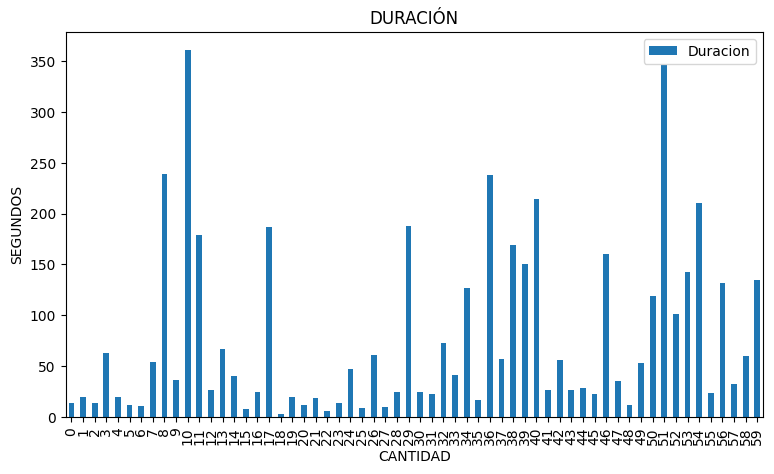

In [ ]:
#Asignar a columna la inf de Duración
columna = 'Duracion'

# Generar y guardar el grafico de Duración
plt.figure(figsize=(9, 5))  # Establece el tamaño de la figura

data[columna].plot(kind='bar')  # Se cambiar 'line' por otro tipo de gráfico como 'bar' o 'scatter'
plt.xlabel('CANTIDAD')
plt.ylabel('SEGUNDOS')
plt.title('DURACIÓN')
plt.legend(loc='best')
# plt.savefig('/content/drive/MyDrive/Projeto AMMD /Duración.png')  # Guarda la figura como imagen PNG
plt.show()

***Frecuencia***

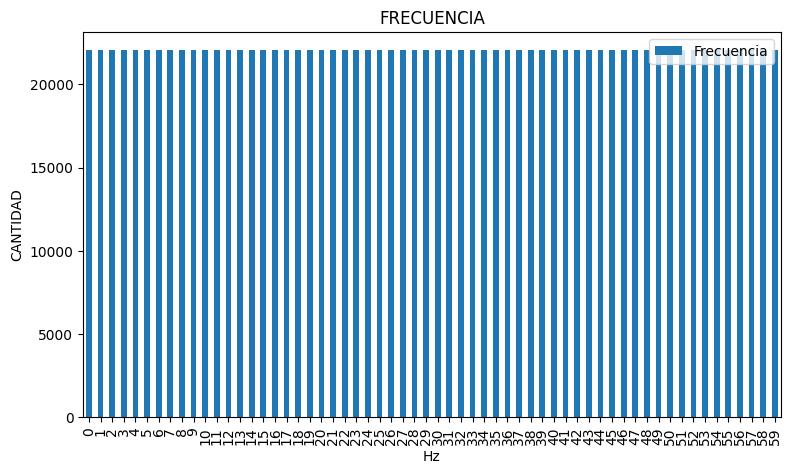

In [ ]:
#A columna1 asignar la inf de Frecuencia
columna1   = 'Frecuencia'

# Generar y guardar el grafico ce Frecuencia
plt.figure(figsize=(9, 5))  # Etablece el tamaño de la figura

data[columna1].plot(kind='bar')  # Se cambiar 'line' por otro tipo de gráfico como 'bar' o 'scatter'
plt.xlabel('Hz')
plt.ylabel('CANTIDAD')
plt.title('FRECUENCIA')
plt.legend(loc='best')
# plt.savefig('/content/drive/MyDrive/Projeto AMMD /Frecuencia.png')  # Guarda la figura como imagen PNG
plt.show()

***Amplitud***

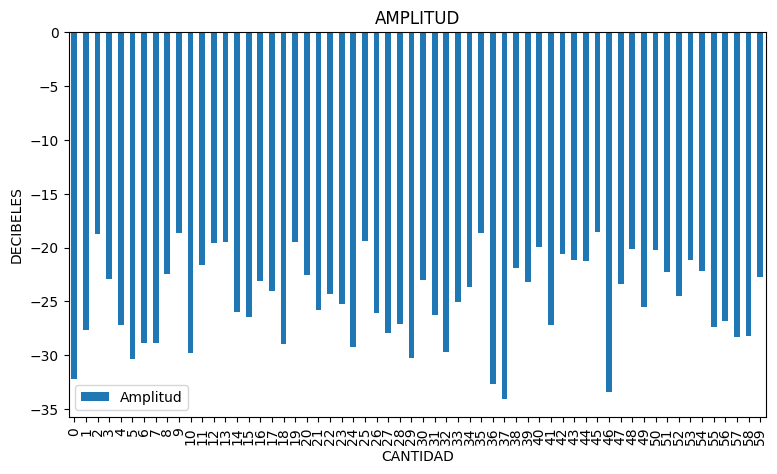

In [ ]:
#A coluna3 asignar la inf de Amplitud
columna3   = 'Amplitud'

#Generar y guardar el grafico de Amplitud
plt.figure(figsize=(9, 5))  # Establece el tamaño de la figura
data[columna3].plot(kind='bar')  # Se cambiar 'line' por otro tipo de gráfico como 'bar' o 'scatter'
plt.xlabel('CANTIDAD')
plt.ylabel('DECIBELES')
plt.title('AMPLITUD')
plt.legend(loc='best')
# plt.savefig('/content/drive/MyDrive/Projeto AMMD /Amplitud.png')  # Guarda la figura como imagen PNG
plt.show()

# **Función para generar los espectogramas**

**Función que genera los espectogramas**

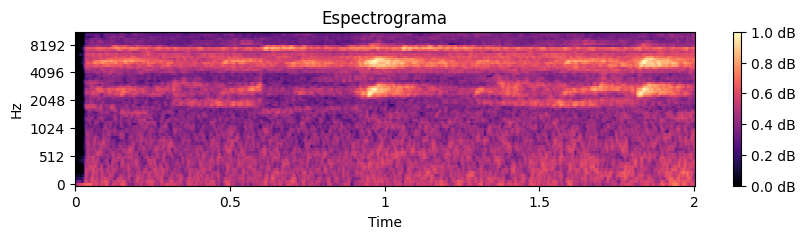

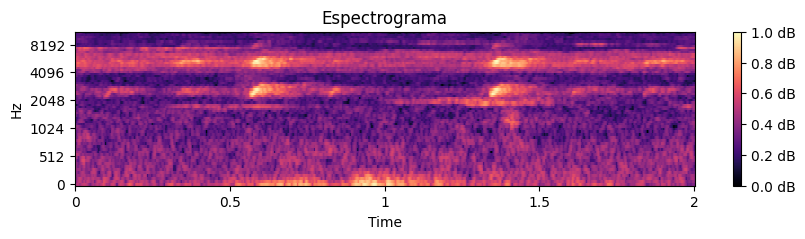

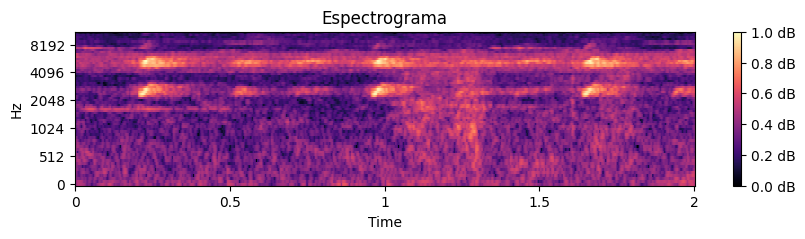

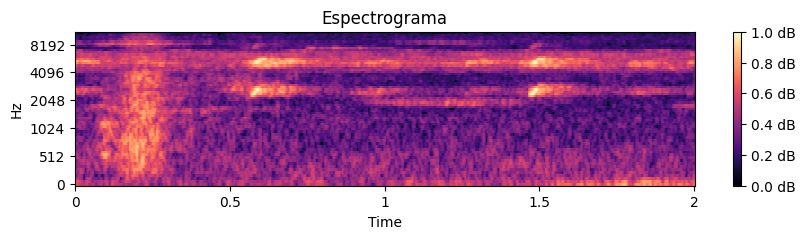

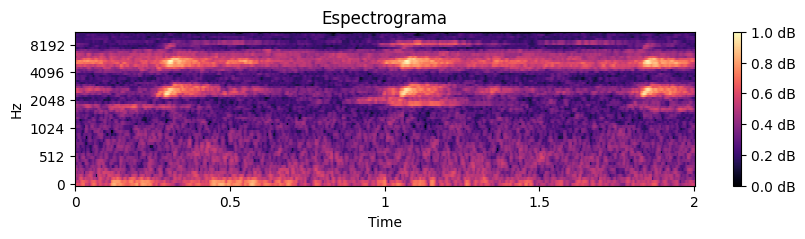

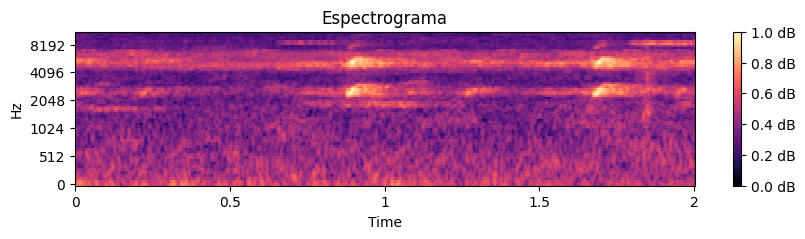

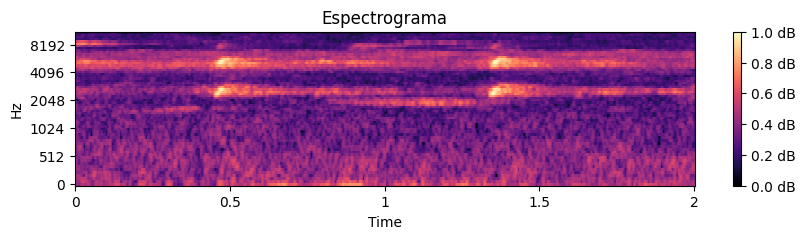

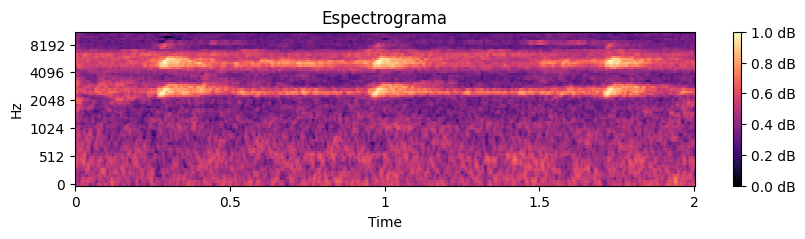

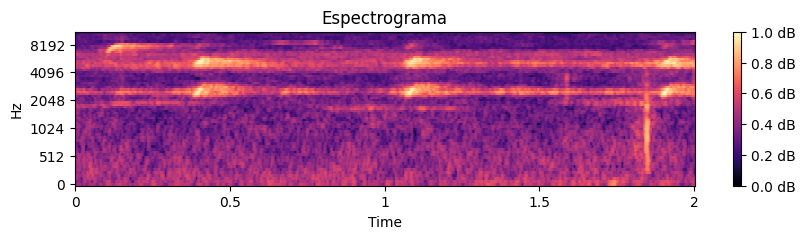

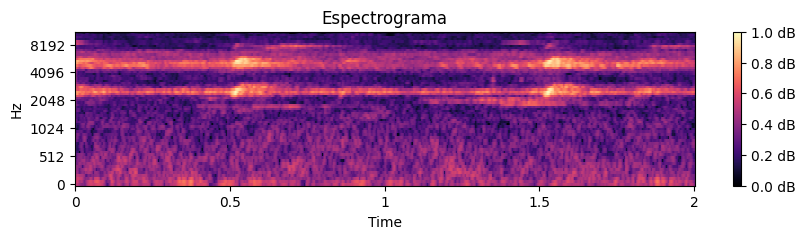

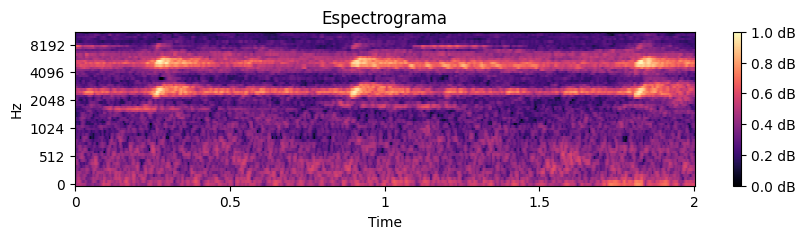

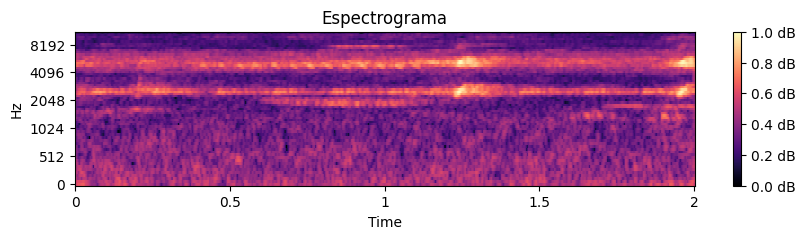

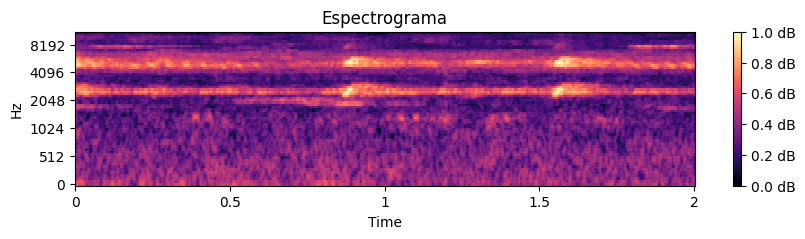

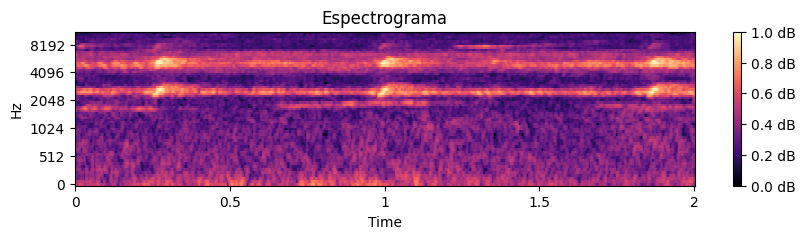

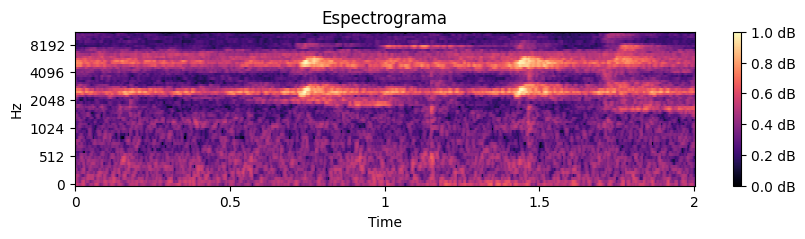

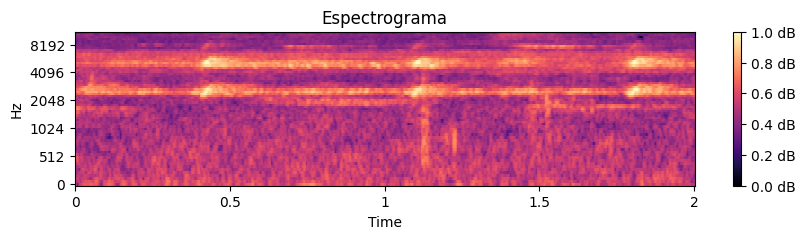

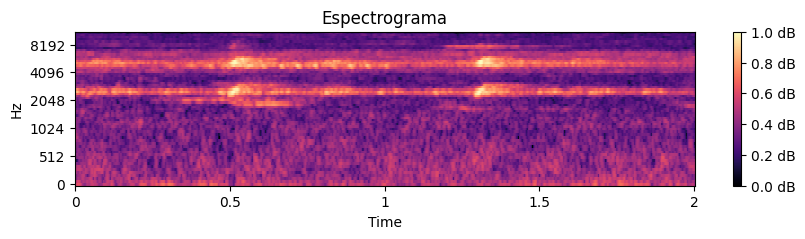

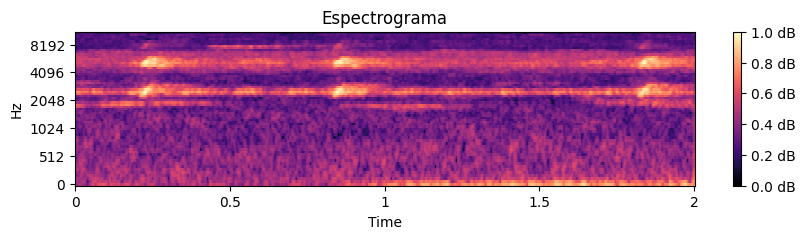

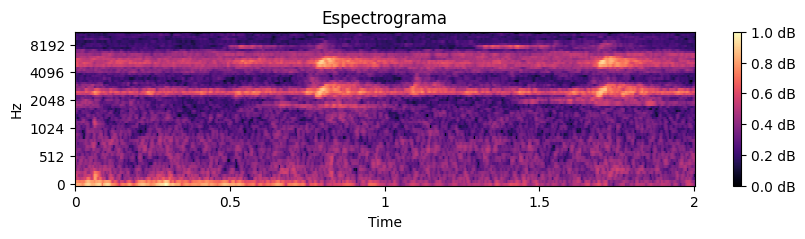

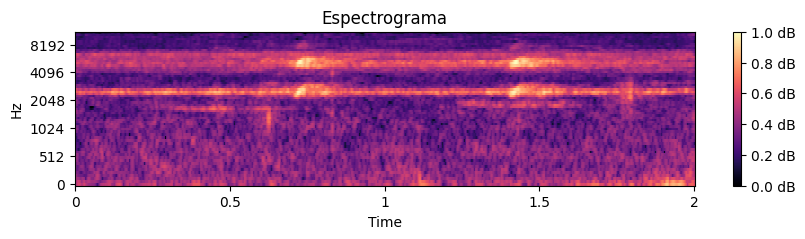

Cantidad de espectrogramas Generados: 20
Cantidad de espectrogramas de Entrenamiento: 14
Cantidad de espectrogramas de Prueba: 3
Cantidad de espectrogramas de Validación: 3


In [ ]:
# Función para dividir los datos en conjuntos de entrenamiento, prueba y validación
def split_data(data, train_ratio, test_ratio, val_ratio):
    total_samples = len(data)
    train_samples = int(total_samples * train_ratio)
    test_samples = int(total_samples * test_ratio)
    val_samples = total_samples - train_samples - test_samples

    # Aleatorizar el orden de los datos
    random.shuffle(data)

    # Dividir los datos en conjuntos
    train_data = data[:train_samples]
    test_data = data[train_samples:train_samples + test_samples]
    val_data = data[train_samples + test_samples:]

    return train_data, test_data, val_data

# Función para generar los segmentos y espectrogramas
def generate_spectrograms(audio_files):
    spectrograms = []  # Lista para almacenar los espectrogramas generados

    for audio_file in audio_files:
        # Cargar el archivo de audio
        audio, sr = librosa.load(directorio_audio + '/' + audio_file)

        # Calcular el tamaño del segmento (2 segundos)
        segment_size = sr * 2

        # Generar los segmentos del audio
        segments = []
        for i in range(0, len(audio) - segment_size, segment_size):
            segment = audio[i:i+segment_size]
            segments.append(segment)

        # Convertir los segmentos a espectrogramas
        for segment in segments:
            spectrogram = librosa.feature.melspectrogram(y=segment,
                                                         sr=sr,
                                                         n_fft=512,
                                                         hop_length=64,
                                                         n_mels=64)
            spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

            # as entradas da rede neural deveriam estar normalizadas entre 0 e 1
            spectrogram = (spectrogram - np.min(spectrogram))/(np.max(spectrogram) - np.min(spectrogram))

            # Agregar el espectrograma a la lista
            spectrograms.append(spectrogram.transpose())

            # Mostrar el espectrograma
            plt.figure(figsize=(10, 2))
            librosa.display.specshow(spectrogram, sr=sr, n_fft=512, hop_length=64, x_axis='time', y_axis='mel')
            plt.colorbar(format='%2.1f dB')
            plt.title('Espectrograma')
            plt.show()

    return spectrograms

# Pasar los nombres de los archivos
# audio_files = ['AdenomeraAndre_1.wav']
audio_files = ['AdenomeraAndre_1.flac'] # estou testando com um arquivo flac
spectrograms = generate_spectrograms(audio_files)

# Dividir los espectrogramas en conjuntos de entrenamiento, prueba y validación
train_data, test_data, val_data = split_data(spectrograms, train_ratio=0.7, test_ratio=0.15, val_ratio=0.15)

# Imprimir la cantidad de espectrogramas generados y la cantidad en cada conjunto
print('Cantidad de espectrogramas Generados:', len(spectrograms))
print('Cantidad de espectrogramas de Entrenamiento:', len(train_data))
print('Cantidad de espectrogramas de Prueba:', len(test_data))
print('Cantidad de espectrogramas de Validación:', len(val_data))



***Copia de la lista***

In [ ]:
specto = spectrograms.copy() #Copia de la lista

***Verificar si la lista no esta vacia***

In [ ]:
#Verificar si la lista esta vacia
if len(specto) > 0:
    n_columns = len(specto[0])
    n_rows = len(specto[0][0])

else:
   print("La lista de espectrogramas está vacía.")

***Ver la lista***

# **Red Self Attention**

In [ ]:
# Convertir los conjuntos de datos a arreglos numpy
train_data_array = np.array(train_data)
test_data_array = np.array(test_data)
val_data_array = np.array(val_data)

In [ ]:
# def my_loss_fn(y_true, y_pred):
#     """
#         Loss do artigo: https://arxiv.org/pdf/2110.03209v1.pdf
#         Não deu bom resultado quando intermediate_dim=32
#     """
#     norm = tf.reduce_sum(tf.square(y_true), axis=-1)
#     squared_difference = tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)
#     div = norm/(squared_difference + 0.001*norm)
#     log_10 = tf.math.log(div) / tf.math.log(10.0)
#     return -10*log_10

In [ ]:
def build(n_columns, n_rows, intermediate_dim=32, summary=False):
    # Crear el modelo de red neuronal con self-attention
    inputs = keras.Input(shape=(n_columns, n_rows))
    inputs = tf.expand_dims(inputs, axis=-1)
    augment_spec = SpecAugment(freq_mask_param=5, time_mask_param=10)(inputs)
    augment_spec_1 = tf.squeeze(augment_spec, axis=-1)
    encoder_output = keras_nlp.layers.TransformerEncoder(intermediate_dim=intermediate_dim,
                                                         num_heads=1,
                                                         dropout=0.1)(augment_spec_1)

    decoder_output = keras_nlp.layers.TransformerDecoder(intermediate_dim=intermediate_dim,
                                                         num_heads=1,
                                                         dropout=0.1)(encoder_output)

    model = keras.Model(inputs=inputs, outputs=decoder_output)
    encoder = keras.Model(inputs=inputs, outputs=encoder_output)
    augment = keras.Model(inputs=inputs, outputs=augment_spec)

    if summary:
        model.summary()

    # Compilar el modelo con un optimizador y las métricas
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mse'])

    return model, encoder, augment

n_columns = len(train_data[0])  # Número de columnas (características) de los espectrogramas (longitud)
n_rows = len(train_data[0][0])  # Número de filas (timesteps) de los espectrogramas
model, encoder, augment = build(n_columns, n_rows, summary=True)

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 690, 64, 1)]      0         
                                                                 
 spec_augment_10 (SpecAugmen  (None, 690, 64, 1)       0         
 t)                                                              
                                                                 
 tf.compat.v1.squeeze_10 (TF  (None, 690, 64)          0         
 OpLambda)                                                       
                                                                 
 transformer_encoder_10 (Tra  (None, 690, 64)          21088     
 nsformerEncoder)                                                
                                                                 
 transformer_decoder_10 (Tra  (None, 690, 64)          21088     
 nsformerDecoder)                                         

Exemplo de augmentation

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_mse",
                                              patience=5,
                                              restore_best_weights=True)]

model, encoder, augment = build(n_columns, n_rows, intermediate_dim=16)

# Entrenar el modelo
history = model.fit(train_data_array,
                    train_data_array,
                    epochs=5000,
                    batch_size=32,
                    validation_data=(val_data_array, val_data_array),
                    callbacks=callbacks)

Epoch 1/5000


Instructions for updating:
Use fn_output_signature instead


1/1 [==============================] - 8s 8s/step - loss: 1.0661 - mse: 1.0661 - val_loss: 0.9871 - val_mse: 0.9871
Epoch 2/5000
1/1 [==============================] - 2s 2s/step - loss: 1.0469 - mse: 1.0469 - val_loss: 0.9704 - val_mse: 0.9704
Epoch 3/5000
1/1 [==============================] - 2s 2s/step - loss: 1.0221 - mse: 1.0221 - val_loss: 0.9605 - val_mse: 0.9605
Epoch 4/5000
1/1 [==============================] - 1s 1s/step - loss: 1.0173 - mse: 1.0173 - val_loss: 0.9527 - val_mse: 0.9527
Epoch 5/5000
1/1 [==============================] - 1s 810ms/step - loss: 0.9954 - mse: 0.9954 - val_loss: 0.9446 - val_mse: 0.9446
Epoch 6/5000
1/1 [==============================] - 1s 818ms/step - loss: 0.9894 - mse: 0.9894 - val_loss: 0.9374 - val_mse: 0.9374
Epoch 7/5000
1/1 [==============================] - 1s 824ms/step - loss: 0.9834 - mse: 0.9834 - val_loss: 0.9315 - val_mse: 0.9315
Epoch 8/5000
1/1 [==============================] - 1s 821ms/step - loss: 0.9810 - mse: 0.9810 - val_

1/1 [==============================] - 0s 42ms/step


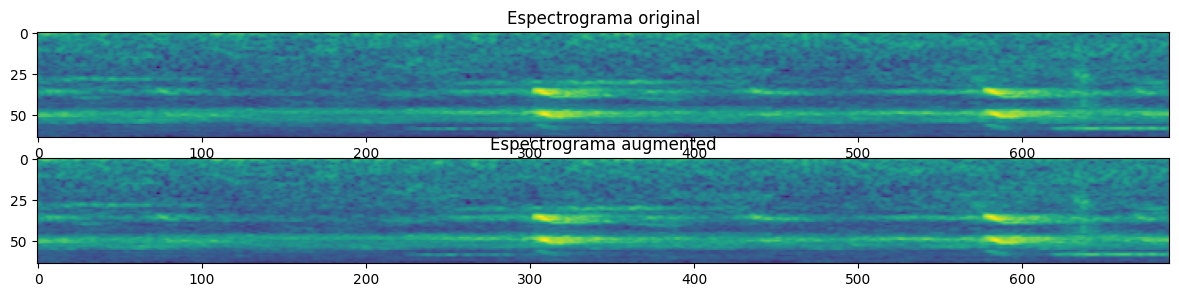

In [ ]:
i = 2
augmented_spectrogram = augment.predict(train_data_array[i:i+1])

plt.figure(figsize=(25, 3))
plt.subplot(2,1,1)
plt.imshow(train_data_array[i].transpose())
plt.title('Espectrograma original')

plt.subplot(2,1,2)
plt.imshow(augmented_spectrogram[0,:,:,0].transpose())
plt.title('Espectrograma augmented')
plt.show()

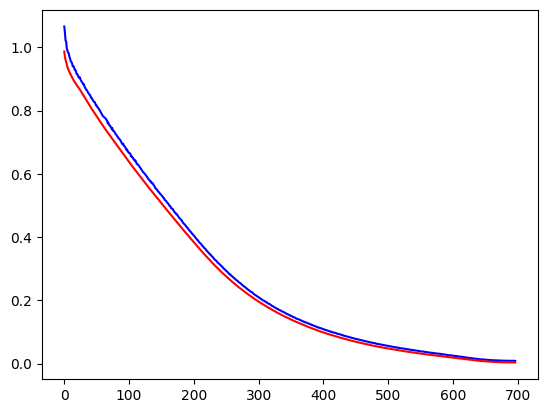

In [ ]:
mse = history.history['mse']
val_mse = history.history['val_mse']

plt.figure()
plt.plot(mse, 'b')
plt.plot(val_mse, 'r')
plt.show()

# **Resultados**

In [ ]:
# Evaluar el modelo en los conjuntos de datos de prueba y validación
test_loss, test_mse = model.evaluate(test_data_array, test_data_array)

# Imprimir las métricas de evaluación
print('Métricas de evaluación en conjunto de prueba:')
print('Loss:', test_loss)
print('Mean Squared Error:', test_mse)

1/1 [==============================] - 0s 91ms/step - loss: 0.0023 - mse: 0.0023
Métricas de evaluación en conjunto de prueba:
Loss: 0.002261803951114416
Mean Squared Error: 0.002261803951114416


## Reconstruções

1/1 [==============================] - 0s 424ms/step


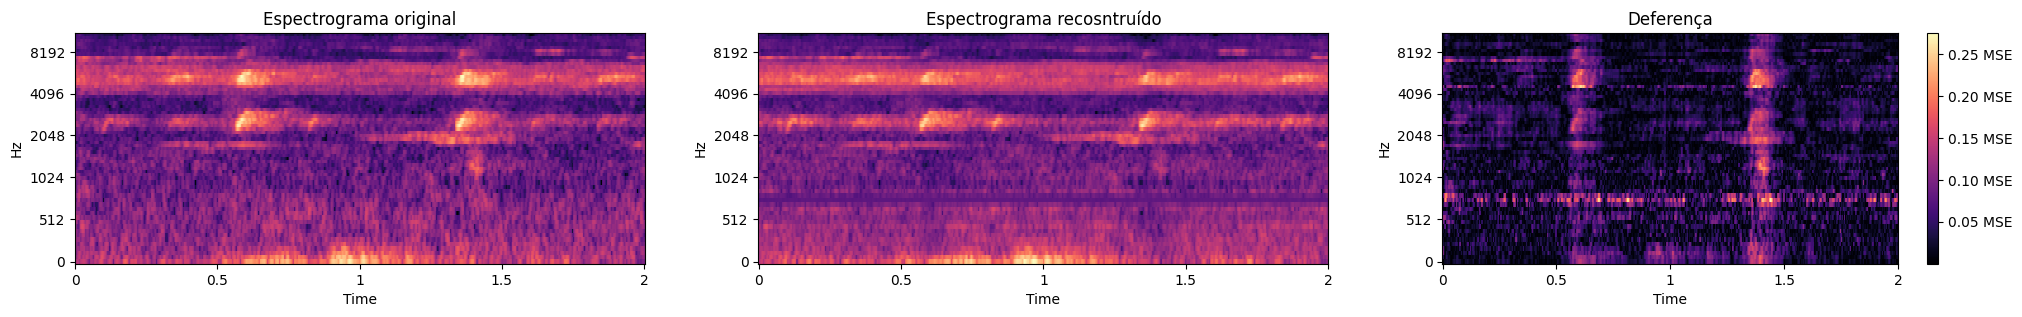

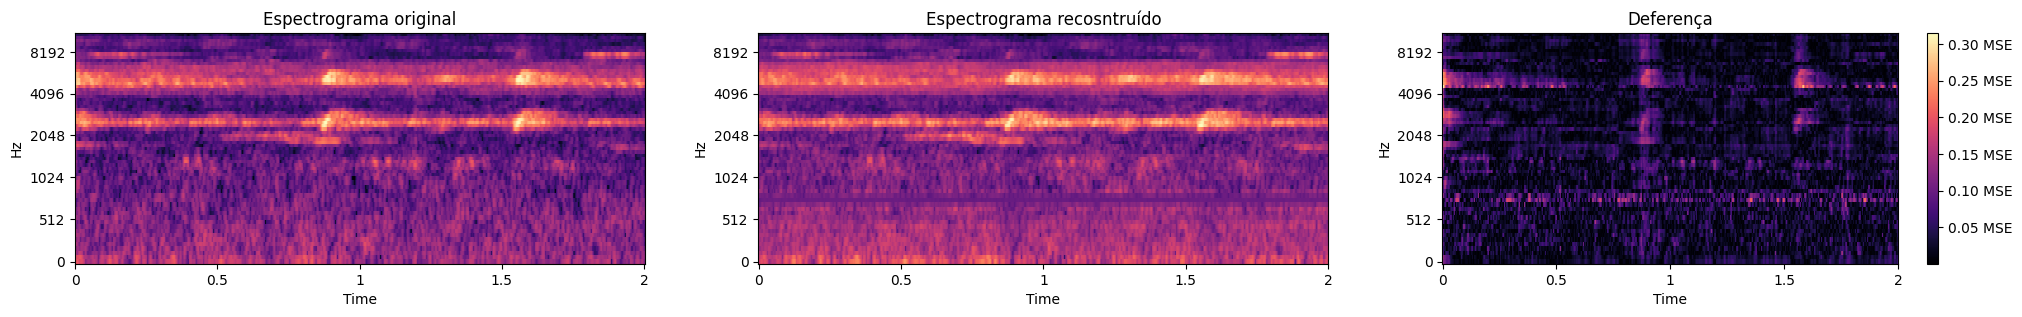

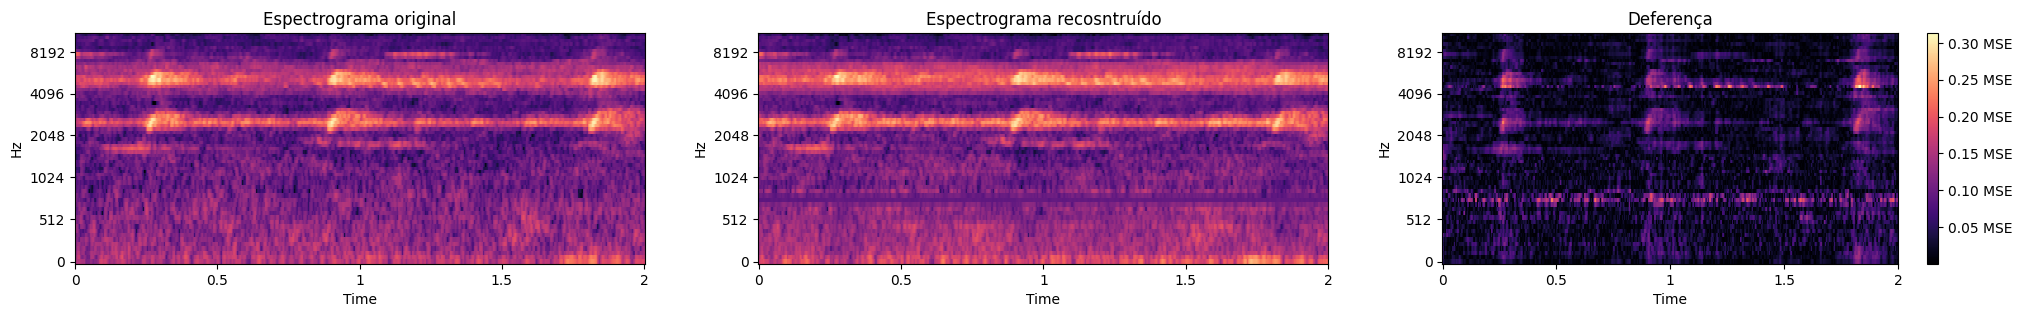

In [ ]:
# Realizar predicciones
test_predictions = model.predict(test_data_array)

# Mostrar el espectrograma
for i in range(test_predictions.shape[0]):
    plt.figure(figsize=(25, 3))
    plt.subplot(1,3,1)
    librosa.display.specshow(test_data_array[i].transpose(),
                             sr=sr, n_fft=512, hop_length=64,
                             x_axis='time', y_axis='mel')
    plt.title('Espectrograma original')

    plt.subplot(1,3,2)
    librosa.display.specshow(test_predictions[i].transpose(),
                             sr=sr, n_fft=512, hop_length=64,
                             x_axis='time', y_axis='mel')
    plt.title('Espectrograma recosntruído')

    plt.subplot(1,3,3)
    librosa.display.specshow(np.abs(test_data_array[i].transpose()-test_predictions[i].transpose()),
                             sr=sr, n_fft=512, hop_length=64,
                             x_axis='time', y_axis='mel')
    plt.colorbar(format='%2.2f MSE')
    plt.title('Deferença')
    plt.show()

## Saída do Encoder


1/1 [==============================] - 0s 336ms/step


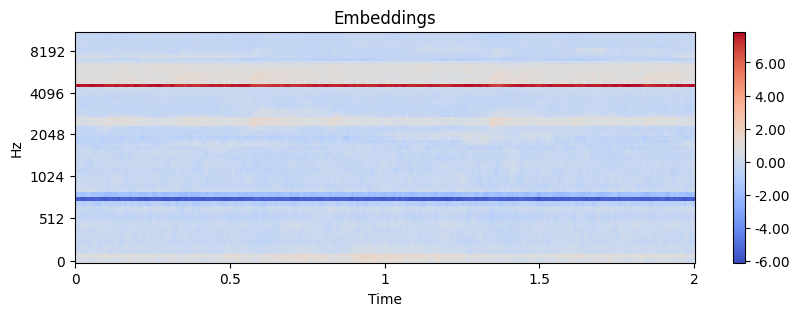

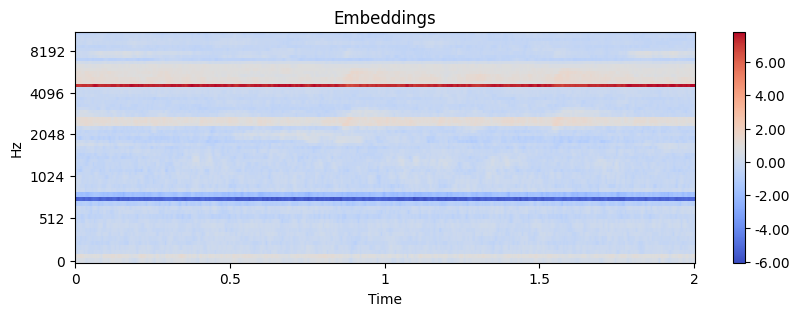

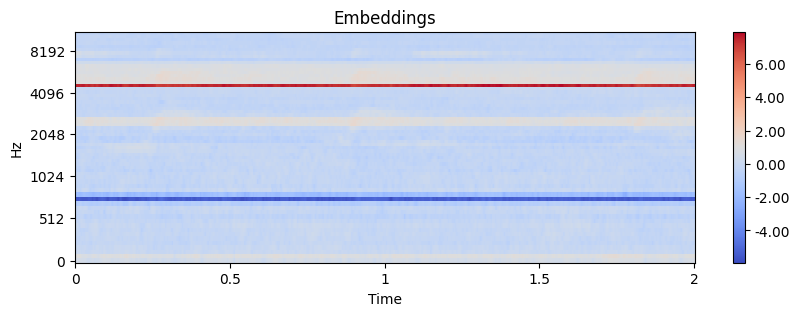

In [ ]:
test_encoder = encoder.predict(test_data_array)

for i in range(test_encoder.shape[0]):
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(test_encoder[i].transpose(),
                             sr=sr, n_fft=512, hop_length=64,
                             x_axis='time', y_axis='mel')
    plt.colorbar(format='%2.2f')
    plt.title('Embeddings')
    plt.show()